
# Supervised Machine Learning

## Object Detection using HOG and SVM



### What is a Feature Descriptor

A feature descriptor is a representation of an image or an image patch that simplifies the image by extracting useful information and throwing away extraneous information.

Typically, a feature descriptor converts an image of size width x height x 3 (channels ) to a feature vector / array of length n. In the case of the HOG feature descriptor, the input image is of size 64 x 128 x 3 and the output feature vector is of length 3780.

This all sounds good, but what is “useful” and what is “extraneous” ? To define “useful”, we need to know what is it “useful” for ? Clearly, the feature vector is not useful for the purpose of viewing the image. But, it is very useful for tasks like image recognition and object detection. The feature vector produced by these algorithms when fed into an image classification algorithms like Support Vector Machine (SVM) produce good results.

In the HOG feature descriptor, the distribution ( histograms ) of directions of gradients ( oriented gradients ) are used as features. Gradients ( x and y derivatives ) of an image are useful because the magnitude of gradients is large around edges and corners ( regions of abrupt intensity changes ) and we know that edges and corners pack in a lot more information about object shape than flat regions.

In [74]:
ENV["JULIA_PKGDIR"]="/Users/abhijith/.julia/v0.6"
using ImageView
using Colors
using Images
using ImageFiltering
using Interact
using ImageFeatures
using LIBSVM

In [75]:
Pkg.dir()

"/Users/abhijith/.julia/v0.6"

In [77]:
n_pos = length(readdir(pos_examples))   # number of positive training examples
n_neg = length(readdir(neg_examples))   # number of negative training examples
n = n_pos + n_neg   

2794

In [78]:
path_to_tutorial = joinpath(pwd(), "data", "dataset")

"/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset"

In [79]:
pos_examples = "$path_to_tutorial/tutorial/humans/"
neg_examples = "$path_to_tutorial/tutorial/nothumans/"

"/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans/"

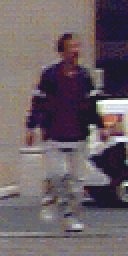

In [80]:
# Example of positive example
pos_ex = load("$pos_examples/per00003.ppm")

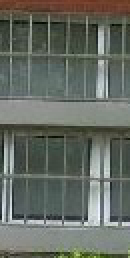

In [81]:
#Example of negative example
neg_ex = load("$neg_examples/1.jpg")

In [17]:
n_pos = length(readdir(pos_examples))   # number of positive training examples
n_neg = length(readdir(neg_examples))   # number of negative training examples
n = n_pos + n_neg   

2794

In [82]:
# Find out the size of the images
size(pos_ex)

(128, 64)

In [83]:
# Let us create an array of vectors, where each vector represents one image (both positive and negative)
# Array to store HOG descriptor of each image. 
# Each image in our training data has size 128x64 and so has a 3780 length

data = Array{Float64}(3780, n) 

3780×2794 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  

In [84]:
 # Vector to store label (1=human, 0=not human) of each image.
labels = Vector{Int}(n)

2794-element Array{Int64,1}:
               0
 140571605273102
               0
 140571594283278
              -8
 140571547134536
              -8
      1320019968
 140732840254688
      4375645138
      4519601744
      4519601664
 140571478040064
               ⋮
               0
               0
               0
               0
               0
               0
               0
               0
               0
 140732840256488
 140732840256648
      4715951360

In [86]:
128*64

8192

In [87]:
size(neg_ex)

(129, 65)

In [89]:
# Find the feature descriptor for all the images

for (i, file) in enumerate([readdir(pos_examples); readdir(neg_examples)])
    filename = "$(i <= n_pos ? pos_examples : neg_examples )/$file"
    println(filename)
    img = load(filename);
    if size(img) != (128, 64)
        img = imresize(img, (128, 64))
    end
    data[:, i] = create_descriptor(img, HOG())
    labels[i] = (i <= n_pos ? 1 : 0)
end

/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00001.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00002.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00003.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00004.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00005.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00006.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00007.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutoria

cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00066.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00067.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00068.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00069.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00070.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00071.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00072.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetec

cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00129.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00130.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00131.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00132.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00133.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00134.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00135.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetec

cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00193.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00194.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00195.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00196.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00197.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00198.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00199.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetec

/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00257.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00258.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00259.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00260.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00261.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00262.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00263.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutoria

cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00322.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00323.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00324.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00325.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00326.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00327.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00328.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetec

cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00387.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00388.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00389.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00390.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00391.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00392.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00393.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetec

cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00451.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00452.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00453.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00454.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00455.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00456.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00457.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetec

cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00515.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00516.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00517.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00518.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00519.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00520.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00521.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetec

cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00579.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00580.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00581.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00582.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00583.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00584.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00585.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetec

/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00643.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00644.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00645.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00646.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00647.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00648.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00649.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutoria

cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00707.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00708.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00709.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00710.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00711.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00712.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00713.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetec

cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00771.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00772.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00773.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00774.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00775.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00776.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00777.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetec

cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00834.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00835.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00836.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00837.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00838.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00839.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00840.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetec

cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00899.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00900.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00901.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00902.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00903.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00904.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/humans//per00905.ppm
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetec

cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1032.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1033.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1034.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1035.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1036.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1037.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1038.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/da

cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1090.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1091.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1092.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1093.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1094.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1095.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1096.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/da

cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1149.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//115.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1150.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1151.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1152.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1153.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1154.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/dat

cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1206.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1207.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1208.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1209.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//121.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1210.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1211.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/dat

/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1264.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1265.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1266.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1267.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1268.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1269.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//127.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothum

cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1322.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1323.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1324.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1325.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1326.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1327.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1328.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/da

/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1381.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1382.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1383.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1384.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1385.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1386.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1387.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothu

/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1439.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//144.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1440.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1441.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1442.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1443.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1444.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothum

/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1499.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//15.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//150.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1500.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1501.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1502.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1503.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothuman

cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1556.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1557.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1558.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1559.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//156.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1560.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1561.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/dat

cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1613.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1614.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1615.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1616.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1617.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1618.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1619.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/da

cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1671.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1672.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1673.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1674.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1675.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1676.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1677.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/da

/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1729.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//173.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1730.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1731.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1732.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1733.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1734.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothum

cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1787.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1788.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1789.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//179.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1790.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1791.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1792.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/dat

/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1844.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1845.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1846.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1847.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1848.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//1849.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//185.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothum

cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//219.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//22.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//220.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//221.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//222.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//223.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//224.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/datas

cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//277.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//278.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//279.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//28.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//280.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//281.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//282.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/datas

/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//335.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//336.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//337.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//338.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//339.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//34.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//340.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//34

cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//393.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//394.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//395.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//396.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//397.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//398.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//399.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/data

/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//450.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//451.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//452.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//453.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//454.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//455.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//456.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//4

cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//509.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//51.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//510.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//511.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//512.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//513.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//514.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/datas

cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//568.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//569.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//57.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//570.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//571.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//572.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//573.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/datas

cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//627.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//628.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//629.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//63.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//630.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//631.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//632.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/datas

cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//687.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//688.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//689.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//69.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//690.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//691.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//692.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/datas

cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//745.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//746.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//747.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//748.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//749.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//75.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//750.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/datas

cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//803.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//804.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//805.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//806.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//807.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//808.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//809.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/data

cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//862.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//863.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//864.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//865.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//866.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//867.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//868.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/data

cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//92.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//920.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//921.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//922.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//923.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//924.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//925.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/datas

cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//978.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//979.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//98.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//980.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//981.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//982.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/dataset/tutorial/nothumans//983.jpg
cell_rows 16
cell_cols 8
/Users/abhijith/work/training/ComputerParadise/ObjectDetection/data/datas

In [90]:
labels

2794-element Array{Int64,1}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

In [91]:
random_perm = randperm(n)
train_ind = random_perm[1:2500]
test_ind = random_perm[2501:end]

model = svmtrain(data[:, train_ind], labels[train_ind]);

In [30]:
# Let us see what randperm does

randperm(10)

10-element Array{Int64,1}:
  5
  3
  4
  7
  8
  9
  1
  6
 10
  2

In [92]:
predicted_labels, decision_values = svmpredict(model, data[:, test_ind]);
@printf "Accuracy: %.2f%%\n" mean((predicted_labels .== labels[test_ind]))*100 # test accuracy should be > 98%

Accuracy: 100.00%


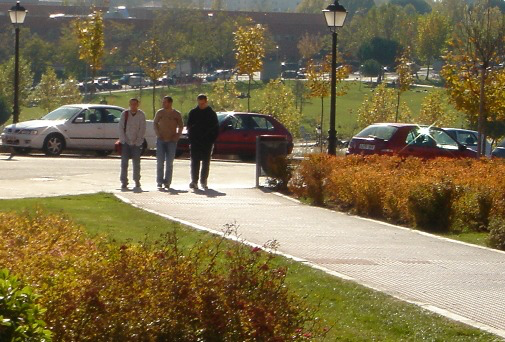

In [93]:
img = load("$path_to_tutorial/tutorial/humans.jpg")

In [94]:
img = load("$path_to_tutorial/tutorial/humans.jpg")
#img1 = load("$path_to_tutorial/tutorial/PennFudanPed/PNGImages/FudanPed00001.png")
img = imresize(img1, size(img))
rows, cols = size(img)

scores = Array{Float64}(22, 45)
descriptor = Array{Float64}(3780, 1)

#Apply classifier using a sliding window approach and store classification score for not-human 
#at every location in score array
for j in 32:10:cols-32
    for i in 64:10:rows-64
        box = img[i-63:i+64, j-31:j+32]
        descriptor[:, 1] = create_descriptor(box, HOG())
        predicted_label, s = svmpredict(model, descriptor);
        scores[Int((i-64)/10)+1, Int((j-32)/10)+1] = s[1]
    end
end

cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8


cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8


cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8


cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8
cell_rows 16
cell_cols 8


In [58]:
size(imghuman)

(342, 505)

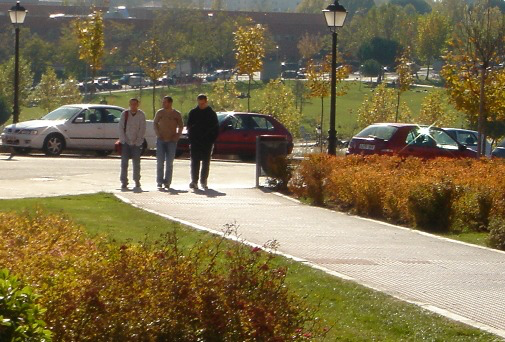

In [57]:
imghuman = load("$path_to_tutorial/tutorial/PennFudanPed/FudanPed00002.png")

In [40]:
size(img1)

(342, 505)

In [72]:
using ImageDraw, ImageView

scores[scores.>0] = 0
object_locations = findlocalminima(scores)

rectangles = [[((i[2]-1)*10+1, (i[1]-1)*10+1), ((i[2]-1)*10+64, (i[1]-1)*10+1), ((i[2]-1)*10+64, (i[1]-1)*10+128), ((i[2]-1)*10+1, (i[1]-1)*10+128)] for i in object_locations];

for rec in rectangles
    draw!(img, Polygon(rec))
end
imshow(img)

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] one(::Type{ColorTypes.RGB4{FixedPointNumbers.Normed{UInt8,8}}}) at /Users/abhijith/.julia/v0.6/ColorVectorSpace/src/ColorVectorSpace.jl:356
 [3] draw!(::Array{ColorTypes.RGB4{FixedPointNumbers.Normed{UInt8,8}},2}, ::ImageDraw.Polygon) at /Users/abhijith/.julia/v0.6/ImageDraw/src/core.jl:137
 [4] macro expansion at ./In[72]:9 [inlined]
 [5] anonymous at ./<missing>:?
 [6] include_string(::String, ::String) at ./loading.jl:522
 [7] include_string(::Module, ::String, ::String) at /Applications/JuliaPro-0.6.2.2.app/Contents/Resources/pkgs-0.6.2.2/v0.6/Compat/src/Compat.jl:174
 [8] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Applications/JuliaPro-0.6.2.2.app/Contents/Resources/pkgs-0.6.2.2/v0.6/IJulia/src/execute_request.jl:158
 [9] (::Compat.#inner#17{Array{Any,1},IJulia.#execute_request,Tuple{ZMQ.Socket,IJulia.Msg}})() at /Applications/JuliaPro-0.6.2.2.app/Contents/Resources/pkgs-0.6.2.2/v0.6/Compat/src/Compat.jl:

Dict{String,Any} with 4 entries:
  "gui"         => Dict{String,Any}(Pair{String,Any}("window", Gtk.GtkWindowLea…
  "roi"         => Dict{String,Any}(Pair{String,Any}("redraw", 192: "map(f-mapp…
  "annotations" => 162: "input-62" = Dict{UInt64,Any}() Dict{UInt64,Any} 
  "clim"        => nothing

In [68]:
object_locations

0-element Array{CartesianIndex{2},1}

In [47]:
object_locations = []

0-element Array{Any,1}

In [49]:
rectangles = []

0-element Array{Any,1}